In [1]:
import pandas as pd
import numpy as np
from aeon.transformations.collection.dictionary_based import SAX
from matplotlib.pyplot import title

from utils import vae_encoding, Params
from model import VAE
from scipy.spatial.distance import squareform, pdist
import seaborn as sns
import torch

/Users/saml/miniconda3/envs/thesis/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
prices_df = pd.read_csv("../datasets/stocks/nasdaq_prices.csv", index_col=0)
prices_df.index = pd.to_datetime(prices_df.index)
tickers = prices_df.columns.to_list()

# monthly returns
returns_df = (prices_df
              .pct_change()
              .dropna()
              .resample('MS')
              .agg(lambda x: (x + 1).prod() - 1)
              )

ret_in_sample_df = returns_df.loc["2011": "2018"]
ret_out_sample_df = returns_df.loc["2018":]

ret_in_sample_np = np.expand_dims(ret_in_sample_df.T.values, axis=1)

returns_df.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SIRI,SNPS,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.029584,0.056248,0.023189,0.018066,0.035905,-0.015724,0.048314,0.115931,-0.075561,-0.008461,...,-0.041420,0.005187,-0.010711,-0.094666,0.039992,-0.018566,0.080578,0.028484,-0.071650,0.000425
2011-02-01,0.040935,0.043873,0.027041,0.043842,0.033677,0.015768,0.000960,0.051731,0.176245,-0.068083,...,0.117284,0.021747,0.113689,-0.008714,0.050133,-0.043749,0.200051,0.076160,0.105385,0.015697
2011-03-01,-0.013307,-0.038841,-0.006960,0.033513,0.048989,-0.017887,-0.017746,-0.049300,-0.066232,0.041301,...,-0.088398,-0.002525,0.127778,0.161574,-0.029486,0.012674,0.026998,-0.073835,-0.074461,0.008684
2011-04-01,0.004649,0.011761,0.023617,0.059443,0.019723,0.038133,0.178711,0.004482,0.058140,0.063611,...,0.206061,-0.009403,0.036330,-0.005405,0.031803,0.004274,0.148550,0.064275,0.109273,0.018418
2011-05-01,-0.006569,0.032191,0.027686,0.013796,-0.044464,0.060456,0.014913,-0.116552,-0.046154,0.064908,...,0.180904,-0.001825,0.063577,0.092029,-0.006473,0.034954,-0.019255,0.025352,-0.015816,0.016851


#### SAX encoding

In [3]:
n_segments_sax = 32
alphabet_size_sax = 16

sax = SAX(n_segments=n_segments_sax, alphabet_size=alphabet_size_sax)
returns_sax = sax.fit_transform(ret_in_sample_np).squeeze()


#### VAE encoding

In [4]:
model_path = "../baseline_models/fc/model.pt"
params_path = "../baseline_models/fc/params.json"

params = Params(params_path)

# Get VAE hyperparams
patch_len, alphabet_size, n_latent, arch = params.patch_len, params.alphabet_size, params.n_latent, params.arch

# Init VAE, load parameters
vae = VAE(patch_len, alphabet_size, n_latent, arch)
vae.load_state_dict(torch.load(model_path))
vae.eval()

returns_vae = vae_encoding(vae, ret_in_sample_np, patch_len)

#### Build Portfolios

In [5]:
hamming_df = pd.DataFrame(squareform(pdist(returns_vae, metric="hamming")), columns=tickers, index=tickers)
corr_df = ret_in_sample_df.corr()

similarity = {"hamming": hamming_df, "pearson": corr_df}

In [6]:
rets = {}
vol = {k: [] for k in list(similarity.keys())}
trials = 10
n_best = 10
n_sample = 1

for i in range(trials):
    for k, v in similarity.items():
        ret_series = []
        for t in tickers:
            # sample one of the least similar stocks to t
            if k == "hamming":
                pf_tickers = v[t].drop(t).nlargest(n_best).sample(n_sample).index.to_list() + [t]
            else:
                pf_tickers = v[t].drop(t).nsmallest(n_best).sample(n_sample).index.to_list() + [t]
    
            pf_rets = ret_out_sample_df[pf_tickers].sum(axis=1) / len(pf_tickers)   # equal-weighted portfolio
            ret_series.append(pf_rets)
            vol[k].append(pf_rets.std())
            
        rets[k] = pd.concat(ret_series, axis=1)

In [12]:
def plot_eq_curve(portfolio_returns: pd.DataFrame, title: str):
    (1+portfolio_returns).cumprod().plot(legend=False, linewidth=1, alpha=0.8, ylim=(-1, 25), title=title)

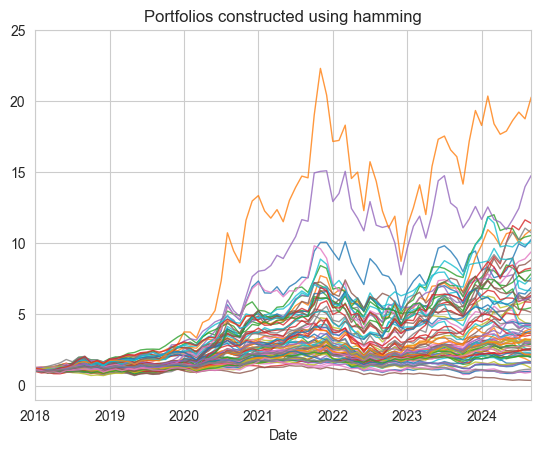

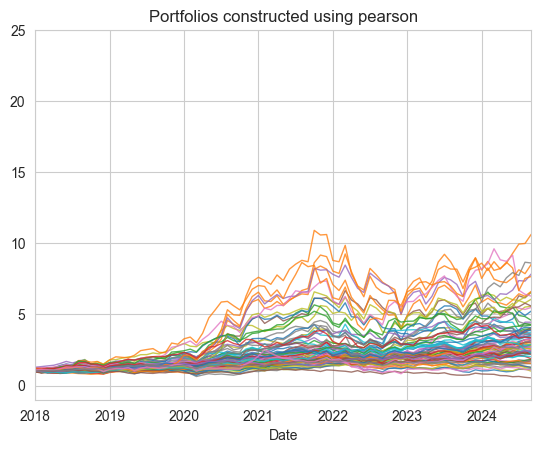

In [13]:
for k in list(similarity.keys()):
    plot_eq_curve(rets[k], f"Portfolios constructed using {k}")

mean volatility:
hamming    31.558385
pearson    25.803182
dtype: float64


Text(0.5, 1.0, 'portfolio volatility')

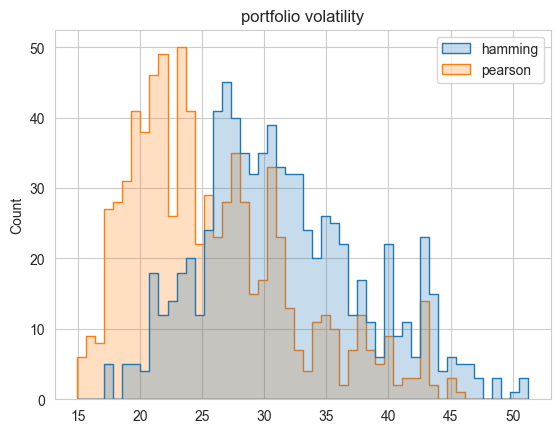

In [11]:
vol_df = pd.DataFrame(vol) * 100 * np.sqrt(12)  # convert monthly to annual vol
print(f"mean volatility:\n{vol_df.mean()}")
sns.histplot(vol_df, element="step", bins=50).set_title("portfolio volatility")

Observation: portfolio hedging with hamming distance doesn't work yet, shows much higher volatility

todo: 
- calculate and compare sharpe ratios?
- use model trained on return time series!!